In [3]:
import pandas as pd
import re
import os

In [4]:
def load_and_merge_mut_rsa(
    mutation_csv,
    rsa_csv,
    gene_name,
    check_aa_match=True
):
    """
    Load mutation and RSA files for a single gene and merge on residue position.
    """

    # Load data
    mut = pd.read_csv(mutation_csv)
    rsa = pd.read_csv(rsa_csv)

    # Drop duplicated mutations
    mut = mut.drop_duplicates(subset=["Mutation"])

    # Extract residue position (e.g. R35Q -> 35)
    mut["Position"] = mut["Mutation"].str.extract(r"(\d+)").astype(int)

    # Rename amino acid columns
    mut = mut.rename(columns={
        "aaref": "WT_AA",
        "aaalt": "Mut_AA"
    })

    rsa = rsa.rename(columns={"ResNum": "Position"})

    # Merge
    merged = mut.merge(
        rsa[["Position", "AA", "RSA"]],
        on="Position",
        how="left"
    )

    # Add gene label
    merged["Gene"] = gene_name

    # Optional amino-acid consistency check
    if check_aa_match:
        merged["AA_match"] = merged["WT_AA"] == merged["AA"]

    return merged


def summarize_by_amino_acid(merged_df):
    """
    Summarize RSA statistics by wild-type amino acid.
    """

    summary = (
        merged_df
        .groupby("WT_AA")
        .agg(
            n=("Mutation", "count"),
            mean_RSA=("RSA", "mean"),
            median_RSA=("RSA", "median"),
            min_RSA=("RSA", "min"),
            max_RSA=("RSA", "max")
        )
        .reset_index()
        .sort_values("WT_AA")
    )

    return summary


In [ ]:
# # -------------------------------
# # Merge multiple mutation datasets (PSEN1)
# # -------------------------------

# # List of mutation files for the same gene
# mutation_files = [
#     "../raw_data/PSEN1_Sun.csv",
#     "../raw_data/PSEN1_Petit.csv",
#     "../raw_data/PSEN1_Pillai.csv"
# ]

# # Read and concatenate the datasets
# mutation_dfs = [pd.read_csv(f) for f in mutation_files]
# merged_mutations = pd.concat(mutation_dfs, ignore_index=True)

# # Drop duplicated mutations (based on 'Mutation' column)
# merged_mutations = merged_mutations.drop_duplicates(subset='Mutation')

# # Save merged dataset (optional)
# merged_mutation_file = "../processed_data/PSEN1_merged.csv"
# merged_mutations.to_csv(merged_mutation_file, index=False)
# print(f"Merged dataset saved to: {merged_mutation_file}")

# # ---- Gene label ----
# GENE_NAME = "PSEN1"
# # ---- File paths ----
# MUTATION_FILE = merged_mutation_file
# RSA_FILE = "../processed_data/PSEN1_AF3_RSA.csv"

Merged dataset saved to: ../processed_data/PSEN1_merged.csv


In [ ]:
# # ---- Gene label ----
# GENE_NAME = "PSEN2"

# # ---- File paths ----
# MUTATION_FILE = "../raw_data/PSEN2_Pillai.csv"
# RSA_FILE = "../processed_data/PSEN2_AF3_RSA.csv"

In [31]:
# ---- Gene label ----
GENE_NAME = "APP"

# ---- File paths ----
MUTATION_FILE = "../raw_data/APP_Pillai.csv"
RSA_FILE = "../processed_data/APP_AF3_RSA.csv"

In [32]:
merged = load_and_merge_mut_rsa(
    mutation_csv=MUTATION_FILE,
    rsa_csv=RSA_FILE,
    gene_name=GENE_NAME
)

merged.head()


,Variants,Mutation,Aβ40 (relative to WT),Significant?,Aβ42 (relative to WT),Significant?.1,Aβ42/40,Significant?.2,variant_id_hg38,variant_id_hg19,...,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding,Position,AA,RSA,Gene,AA_match
0,APP:p.Ala201Val,A201V,0.910310,No,0.90097,No,0.989730,No,21-26051060-G-A,21-27423376-G-A,...,0.26318,1.452508,-0.242586,0.29714,1.687206,201,A,0.785,APP,True
1,APP:p.Ala235Val,A235V,0.493400,Yes,0.58420,Yes,1.185700,No,21-26022001-G-A,21-27394317-G-A,...,0.26176,1.443685,-0.237169,0.29902,1.699391,235,A,0.843,APP,True
2,APP:p.Asp243Asn,D243N,0.995382,No,0.98841,No,0.992705,No,21-26021978-C-T,21-27394294-C-T,...,0.27742,1.541930,-0.332699,0.26733,1.498262,243,D,0.701,APP,True
3,APP:p.Glu246Lys,E246K,1.174600,No,1.24830,No,0.937060,No,21-26021969-C-T,21-27394285-C-T,...,0.42365,2.571805,0.095528,0.44048,2.716294,246,E,0.916,APP,True
4,APP:p.Arg468His,R468H,0.864000,No,0.89070,No,1.029830,No,21-25975125-C-T,21-27347438-C-T,...,0.82755,7.864946,0.707836,0.82882,7.901620,468,R,0.547,APP,True


In [33]:
summary_by_aa = summarize_by_amino_acid(merged)
summary_by_aa


,WT_AA,n,mean_RSA,median_RSA,min_RSA,max_RSA
0,A,6,0.420000,0.4210,0.025,0.843
1,D,1,0.701000,0.7010,0.701,0.701
2,E,3,0.825667,0.8830,0.678,0.916
3,H,1,0.866000,0.8660,0.866,0.866
4,I,1,0.456000,0.4560,0.456,0.456
5,K,3,0.526000,0.5390,0.287,0.752
6,L,2,0.607000,0.6070,0.607,0.607
7,P,2,0.649000,0.6490,0.649,0.649
8,R,1,0.547000,0.5470,0.547,0.547
9,S,1,0.671000,0.6710,0.671,0.671


In [34]:
low_rsa_aa = summary_by_aa.loc[
    summary_by_aa["mean_RSA"] < 0.25
]

print(f"Amino acids with mean RSA < 0.25 in {GENE_NAME}:")
print(f"Count: {low_rsa_aa.shape[0]}\n")

low_rsa_aa


Amino acids with mean RSA < 0.25 in APP:
Count: 2



,WT_AA,n,mean_RSA,median_RSA,min_RSA,max_RSA
11,V,1,0.006,0.006,0.006,0.006
12,Y,1,0.196,0.196,0.196,0.196


In [35]:
# merged.to_csv(f"../processed_data/{GENE_NAME}_mutation_RSA_merged.csv", index=False)
summary_by_aa.to_csv(f"../processed_data/{GENE_NAME}_RSA_summary_by_AA.csv", index=False)

In [36]:
# Any mismatches between WT amino acid and RSA AA?
merged.loc[
    merged["AA_match"] == False,
    ["Mutation", "Position", "WT_AA", "AA"]
]

,Mutation,Position,WT_AA,AA


Figure saved to: ../figures/mean_RSA_by_AA_APP.png


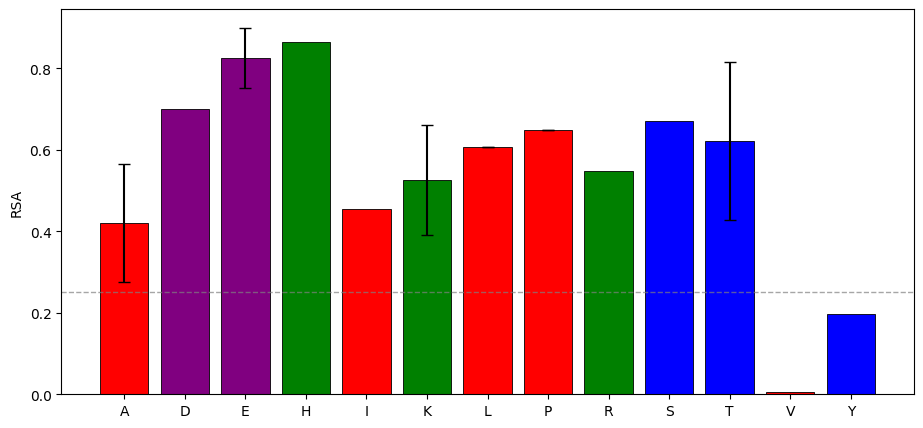

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Amino acid groups
aa_groups = {
    "nonpolar": {
        "aas": ["G", "A", "V", "P", "L", "I", "M", "W", "F"],
        "color": "red"
    },
    "polar": {
        "aas": ["C", "S", "T", "Y", "N", "Q"],
        "color": "blue"
    },
    "negative": {
        "aas": ["D", "E"],
        "color": "purple"
    },
    "positive": {
        "aas": ["K", "R", "H"],
        "color": "green"
    }
}

# Assign color to each amino acid
def aa_to_color(aa):
    for group in aa_groups.values():
        if aa in group["aas"]:
            return group["color"]
    return "gray"

# ---- Aggregate statistics from merged ----
stats = (
    merged
    .groupby("WT_AA")["RSA"]
    .agg(
        mean_RSA="mean",
        std_RSA="std",
        n="count"
    )
    .reset_index()
)

# Standard error
stats["sem_RSA"] = stats["std_RSA"] / np.sqrt(stats["n"])

# Sort amino acids alphabetically (keeps x-axis clean)
stats = stats.sort_values("WT_AA")

# Colors
colors = stats["WT_AA"].apply(aa_to_color)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(11, 5))

ax.bar(
    stats["WT_AA"],
    stats["mean_RSA"],
    yerr=stats["sem_RSA"],
    capsize=4,
    color=colors,
    edgecolor="black",
    linewidth=0.6
)

# Reference line
ax.axhline(0.25, linestyle="--", linewidth=1, color="gray", alpha=0.7)

# Labels
ax.set_ylabel("RSA")

# # Legend
# legend_handles = [
#     plt.Rectangle((0, 0), 1, 1, color="red", label="Non-polar"),
#     plt.Rectangle((0, 0), 1, 1, color="blue", label="Polar"),
#     plt.Rectangle((0, 0), 1, 1, color="purple", label="Negative charge"),
#     plt.Rectangle((0, 0), 1, 1, color="green", label="Positive charge"),
# ]
# ax.legend(handles=legend_handles)

# ---- FORCE DRAW before saving ----
fig.canvas.draw()

# ---- Save figure ----
output_fig = f"../figures/mean_RSA_by_AA_{GENE_NAME}.png"
fig.savefig(
    output_fig,
    dpi=600,
    bbox_inches="tight",
    facecolor="white"
)

print(f"Figure saved to: {output_fig}")

plt.show()
